In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import zipfile

def load_embeddings(embeddings_zip, embeddings_file):
  """Loads embeddings from a Numberbatch file inside a zip archive.

  Args:
      embeddings_zip: Path to the 'numberbatch-en.zip' file.
      embeddings_file: Name of the 'numberbatch-en.txt' file within the zip archive.

  Returns:
      A tuple of (embeddings, vocabulary)
          embeddings: A NumPy array of shape (num_concepts, embedding_dim)
          vocabulary: A list of concept labels in the order they appear in the embeddings array
  """

  with zipfile.ZipFile(embeddings_zip, 'r') as zip_ref:
    with zip_ref.open(embeddings_file) as f:
      header = f.readline().decode('utf-8').split()  # Read dimensions
      num_concepts, embedding_dim = int(header[0]), int(header[1])
      print("num_concepts: ", num_concepts, " embedding dim: ", embedding_dim)

      embeddings = np.zeros((num_concepts, embedding_dim))
      vocabulary = []

      for i, line in enumerate(f):
        parts = line.decode('utf-8').strip().split()  # Decode bytes
        vocabulary.append(parts[0])

        try:
          embeddings[i] = np.array(parts[1:], dtype=np.float32)
        except ValueError as e:
          print(f"Error on line {i+2}: {line}")
          print(f"Error message: {e}")

  return embeddings, vocabulary

# Load the embeddings and vocabulary
embeddings, vocabulary = load_embeddings("/content/drive/My Drive/WikiData/numberbatch-en.zip", "numberbatch-en.txt")
print(embeddings.shape)
print(len(vocabulary))


num_concepts:  516782  embedding dim:  300
(516782, 300)
516782


In [2]:
import pandas as pd
import json
from transformers import AutoTokenizer, AutoModel

# Load pre-trained BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") # Or another suitable BERT model
model1 = AutoModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import gzip
conceptnet_data = {}
with gzip.open("/content/drive/My Drive/WikiData/conceptnet-assertions-5.7.0.csv.gz", 'rt') as f:  # 'rt' for reading text
    for line in f:
        _, relation, start_concept, end_concept, extra_info = line.split('\t')
        extra_info_dict = json.loads(extra_info)  # Load JSON from extra_info

        if 'surfaceText' in extra_info_dict:
            surface_text = extra_info_dict['surfaceText']

            if start_concept not in conceptnet_data:
                 conceptnet_data[start_concept] = []
            if surface_text != None and surface_text!="null":
              conceptnet_data[start_concept].append(surface_text)  # Store the surface text
            # Include sense_label
            if 'sense_label' in extra_info_dict:
                sense_label = extra_info_dict['sense_label']
            else:
                sense_label = None  # Handle cases where it might be absent
            if 'label' in extra_info_dict:
                label = extra_info_dict['label']
            else:
                label = None
            if label != None and label!="null":
                conceptnet_data[start_concept].append(label)
            if sense_label != None and sense_label!="null":
                conceptnet_data[start_concept].append(sense_label)





In [ ]:
test = list(conceptnet_data.keys())[50:60]
print(len(list(conceptnet_data.keys())))

for t in test:
  print(t,": ",conceptnet_data[t])

In [ ]:
print(vocabulary.index("able"))

s= "/c/en/able"

print(s[6:])
print(s[6])
print(s[:6])

In [ ]:
embedding_lookup = {concept_label: idx for idx, concept_label in enumerate(vocabulary)}

In [ ]:
import requests
import torch

import gzip
import json
import requests
import torch
import pandas as pd
def get_concept_description(concept_label):
    if concept_label in conceptnet_data:
        return conceptnet_data[concept_label]
    else:
        print("No descriptions found for:", concept_label)
        return []

# Create an empty list to store the data for the dataframe
data = []


i=0
# Iterate directly through conceptnet_data
for concept_label, descriptions in conceptnet_data.items():
    if concept_label.split('/')[1]!='en':
      continue
    if descriptions:
        try:
            embedding = embeddings[embedding_lookup[concept_label.split('/')[2]]]
        except:
            print("ERROR: ",concept_label)
            embedding = None  # Handle cases where concept_label might not be in 'vocabulary'
            continue
        i=i+1
        if i%250==0:
          print(i,": ",concept_label)
        text_embeddings = []
        for description in descriptions:
            inputs = tokenizer(description, padding=True, truncation=True, return_tensors="pt")
            with torch.no_grad():
                outputs = model1(**inputs)
                token_embeddings = outputs.last_hidden_state[:,0,:]
            text_embeddings.append(token_embeddings)
        data.append({'text': text_embeddings, 'embedding': embedding})
# Create the pandas dataframe
df = pd.DataFrame(data)

# Display the dataframe
print(df)
print(len(df))

In [ ]:
# Save the dataframe as a CSV file
df.to_csv("concept_embeddings.csv")

In [ ]:
df = pd.DataFrame(data)
df.to_csv("concept_embeddings.csv")
print(len(df))

In [2]:
import requests
import torch

import gzip
import json
import requests
import torch
import pandas as pd
import zipfile
df = pd.read_csv('/content/drive/My Drive/WikiData/concept_embeddings (2).csv')
df2 = pd.read_csv('clusterData.csv')
df['cluster'] = df2['cluster']
del df2

In [3]:
import re

def convert_tensor_string(tensor_str):
    # Remove unnecessary characters
    clean_str = re.sub(r"\[|\]", "", tensor_str)

    # Split values into a list of strings
    str_values = clean_str.split()

    # Convert strings to floats and create a tensor
    float_values = [float(val) for val in str_values]
    tensor = torch.tensor(float_values)

    return tensor
df['embedding'] = df['embedding'].apply(convert_tensor_string)


In [ ]:

import torch
import re


def extract_tensors(tensor_string):
    # Preprocessing: Remove extra characters if necessary
    clean_string = tensor_string.strip()

    # Split by a reliable delimiter
    tensor_substrings = clean_string.split("tensor(")[1:]

    tensors = []
    for substring in tensor_substrings:
        # Remove brackets and split into numbers
        clean_values = substring.strip("[])\n").split(",")
        clean_values = [val.strip() for val in clean_values]  # Remove leading/trailing spaces
        clean_values = [val.rstrip("])") for val in clean_values]  # Remove extra "])"
        float_values = []
        for val in clean_values:
          if val != "":
            float_values.append(float(val))
        # Convert to floats and create a tensor
        tensor = torch.tensor(float_values)
        tensors.append(tensor)

    # Create the final tensor of tensors
    tensor_of_tensors = torch.stack(tensors)
    return tensor_of_tensors

df['text'] = df['text'].apply(extract_tensors)

In [ ]:
import pickle
with open('processed_data.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
import pickle
import requests
import torch

import gzip
import json
import requests
import torch
import pandas as pd
import zipfile
with open('processed_data.pkl', 'rb') as f:
    df = pickle.load(f)

# Access your data (tensors are already in the correct format)
embeddings = df['embedding'].values
print(embeddings[0])  # Access an embedding tensor directly

In [ ]:
torch.cuda.empty_cache()
del model
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available: ", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available")

CUDA is not available


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, latent_size)
        self.linear_mu = nn.Linear(latent_size, latent_size)
        self.linear_logvar = nn.Linear(latent_size, latent_size)

    def forward(self, x):
        #print("encoder1: ",x.shape)
        out = torch.relu(self.linear1(x))
        #print("encoder2: ",out.shape)
        out = torch.relu(self.linear2(out))
        out = torch.relu(self.linear3(out))
        out = torch.relu(self.linear4(out))
        #print("encoder3: ",out.shape)
        mu = self.linear_mu(out)
        logvar = self.linear_logvar(out)

        # Reparameterization trick for backpropagation through sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)  # Sample from the latent distribution
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_size, decoder_hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, decoder_hidden_size)
        self.linear2 = nn.Linear(decoder_hidden_size, decoder_hidden_size)
        self.output_layer = nn.Linear(decoder_hidden_size, output_size)

    def forward(self, z):
        #print("decoder 1: ",z.shape)
        #print("decoder 1: ",z)
        out = torch.relu(self.linear1(z))
        out = torch.relu(self.linear2(out))
        out = self.output_layer(out)
       # print("decoder 2: ",out)
        return out

class SentenceAttention(nn.Module):
    def __init__(self, attention_hidden_size):
        super().__init__()
        self.linear = nn.Linear(attention_hidden_size, attention_hidden_size).to(device)

    def forward(self, encoder_outputs):
      # Transform x using a linear layer; output shape will be (sq, b, hidden_size)
      x_transformed = self.linear(encoder_outputs)
      # Step 2: Compute attention scores using softmax across the sequence dimension (sq)
      # Attention scores shape: (sq, b, hidden_size) -> (b, sq, hidden_size) for softmax
      x_transposed = x_transformed.transpose(0, 1)  # Transposing for softmax operation
      attention_scores = F.softmax(x_transposed, dim=1)  # Applying softmax; shape remains (b, sq, hidden_size)

      # Step 3: Apply attention scores to the original input tensor
      # For weighted sum, first transpose x back: (sq, b, hidden_size) -> (b, sq, hidden_size)
      x = encoder_outputs.transpose(0, 1)  # Transposing x to match attention_scores shape
      # Compute the context vector as the weighted sum of the input vectors
      # (b, sq, hidden_size) * (b, sq, hidden_size) -> (b, hidden_size) after summing over sq dimension
      context_vector = torch.sum(attention_scores * x, dim=1)
      return context_vector

class TextVAE(nn.Module):
    def __init__(self, bert_embedding_size, hidden_size, latent_size, num_labels=None):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=bert_embedding_size,
            nhead=8,  # Number of attention heads
            dim_feedforward=hidden_size, # Dim. of feedforward network
            batch_first=False
        ).to(device)
        self.bert_size = bert_embedding_size
        # Stack Multiple Transformer Layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=5).to(device)
        self.encoder = Encoder(bert_embedding_size, hidden_size, latent_size).to(device)
        self.decoder = Decoder(latent_size, hidden_size, bert_embedding_size).to(device)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=bert_embedding_size,
            nhead=8,
            dim_feedforward=hidden_size,
            batch_first=False
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=5).to(device)
        if num_labels is not None:
          self.condition_layer = nn.Linear(num_labels, hidden_size).to(device)
          self.cbn = ConditionalBatchNorm1d(bert_embedding_size,hidden_size).to(device)
        self.z=None

    def forward(self, text_embeddings,condition=None):
        #print("textVAE1: ",text_embeddings.shape)
        #print(text_embeddings)
        out = self.transformer_encoder(text_embeddings)
        #print("transformer: ",out.shape)
        #print(out)
        attention_layer = SentenceAttention(self.bert_size).to(device)  # Initialize attention
        context = attention_layer(out).to(device)  # Apply attention
        #print("textVAE2: ",context.shape)
        #print(context)
        if condition is not None:
            condition = condition.to(device)
            condition_encoding = self.condition_layer(condition).to(device)
            context = self.cbn(context, condition_encoding).to(device)
        # Encoding and Decoding
        z, mu, logvar = self.encoder(context)
        #print("textVAE3: ",z.shape)
        #print(z)
        text_recon = self.decoder(z)
        #print("textVAE4: ",text_recon.shape)
        #print(text_recon)
        output = self.transformer_decoder(text_recon, context).to(device)  # Transformer for final output embeddings
        #print("textVAE5: ",output.shape)
        #print(output)
        self.z=z
        return output, z, mu, logvar


class KGVAE(nn.Module):
    def __init__(self, kg_embedding_size, hidden_size, latent_size, num_labels=None):
        super().__init__()
        self.encoder = Encoder(kg_embedding_size, hidden_size, latent_size).to(device)
        self.decoder = Decoder(hidden_size, hidden_size, kg_embedding_size).to(device)
        self.linear = nn.Linear(kg_embedding_size, hidden_size).to(device)
        if num_labels is not None:
          self.condition_layer = nn.Linear(num_labels, hidden_size).to(device)
          self.cbn = ConditionalBatchNorm1d(latent_size,hidden_size).to(device)
        self.linear3 = nn.Linear(latent_size, hidden_size).to(device)
        self.condition_layer2 = nn.Linear(latent_size, hidden_size).to(device) # TextVAE embedding
        self.cbn2 = ConditionalBatchNorm1d(hidden_size,hidden_size).to(device)
        self.z=None
        self.linear2 = nn.Linear(latent_size, latent_size).to(device)

    def forward(self, kg_embeddings, condition = None, textVAE = None,z1=False):
        if z1==False:
          z, mu, logvar = self.encoder(kg_embeddings) # Update usage
        else:
          z = self.linear2(kg_embeddings)
        if condition is not None:
            condition_encoding = self.condition_layer(condition).to(device)
            kg_context = self.cbn(z, condition_encoding).to(device) # Renamed
           # print("kg_con: ",kg_context)
            out = self.linear3(kg_context)
            textVAE_encoding = self.condition_layer2(textVAE).to(device)
            #print("out: ",out.shape," cd2: ",textVAE_encoding.shape)
            kg_context2 = self.cbn2(out, textVAE_encoding).to(device) # Renamed
            kg_recon = self.decoder(kg_context2)
        else:
          out = self.linear3(z)
          textVAE_encoding = self.condition_layer2(textVAE).to(device)
          #print("out: ",out.shape," cd2: ",textVAE_encoding.shape)
          kg_context2 = self.cbn2(out, textVAE_encoding).to(device) # Renamed
          kg_recon = self.decoder(kg_context2)

        if z1:
          return kg_recon, z
        else:
          return kg_recon, z, mu, logvar


import torch
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, num_clusters):
        super().__init__()
        self.num_clusters = num_clusters
        self.linear0 = nn.Linear(latent_size, hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.bn_text = ConditionalBatchNorm1d(hidden_size, latent_size)
        self.bn_cluster = ConditionalBatchNorm1d(hidden_size, num_clusters)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, hidden_size)
        self.linear7 = nn.Linear(hidden_size, hidden_size)
        self.linear8 = nn.Linear(hidden_size, hidden_size)
        self.linear9 = nn.Linear(hidden_size, hidden_size)
        self.linear10 = nn.Linear(hidden_size, hidden_size)
        self.linear11 = nn.Linear(hidden_size, latent_size)  # Changed output size

    def forward(self, text_z, noise, cluster_label):
        cluster_encoding = F.one_hot(cluster_label.long(), num_classes=self.num_clusters).to(device).float()
        out = self.linear0(noise)
        out_text = self.bn_text(out, text_z)
        out = self.linear1(out_text)
        out = self.linear2(out)
        out = self.linear3(out)
        out = self.linear4(out)
        out = self.linear5(out)
        out_cluster = self.bn_cluster(out, cluster_encoding)
        out = self.linear6(out)
        out = self.linear7(out)
        out = self.linear8(out)
        out = self.linear9(out)
        out = self.linear10(out)
        fake_kg_z = self.linear11(out)  # No more batch norm here
        return fake_kg_z



class ConditionalBatchNorm1d(nn.Module):
    def __init__(self, num_features, num_conditions):
        super().__init__()
        self.num_features = num_features

        # Learnable scale and bias parameters, conditioned on the input 'condition'
        self.gamma_layer = nn.Linear(num_conditions, num_features)
        self.beta_layer = nn.Linear(num_conditions, num_features)

    def forward(self, input, condition):
        #print("input: ",input)
        #print("condition: ",condition)
        out = F.batch_norm(input, None, None, training=True).to(device)  # Standard batch normalization
        #print("out: ",out.shape)
        gamma = self.gamma_layer(condition).to(device)
        beta = self.beta_layer(condition).to(device)

        # Apply scaling and shifting
        out = gamma * out + beta

        return out


class Discriminator(nn.Module):
    def __init__(self, kg_latent_size):
        super().__init__()
        self.linear1 = nn.Linear(kg_latent_size, 4)
        self.linear2 = nn.Linear(4, 2)
        self.output_layer = nn.Linear(2, 1)

    def forward(self, z):
        out = torch.relu(self.linear1(z))
        out = torch.relu(self.linear2(out))
        out = self.output_layer(out)
        return out  # Output for classification (real or fake)


In [ ]:
import pandas as pd
from sklearn.cluster import OPTICS

# Initialize SentenceAttention model (assuming 768-dim embeddings)
attention_model = SentenceAttention(768)

# Create data for OPTICS
concatenated_data = []
for index, row in df.iterrows():
    text_embedding = torch.tensor(row['text']) # Convert to PyTorch tensor
    kg_embedding = torch.tensor(row['embedding'])  # Convert to PyTorch tensor

    # Calculate context vector using SentenceAttention
    context_vector = attention_model(text_embedding)

    # Concatenate context vector and KG embedding
    combined_embedding = torch.cat((context_vector, kg_embedding))

    # Append to the data list
    concatenated_data.append(combined_embedding.tolist())  # Convert Tensor to list for OPTICS

from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import cosine_similarity

# Perform OPTICS clustering using the precomputed similarity matrix
optics = OPTICS(min_samples=100, metric='cosine')
optics.fit(concatenated_data)

# **3. Access Cluster Information**

# Get cluster labels
cluster_labels = optics.labels_

# Get reachability distances (useful for understanding cluster structure)
reachability_distances = optics.reachability_

# Explore and utilize the clustering results as needed.
# You might want to create a new column in your 'df' DataFrame
# to store the cluster labels.


In [ ]:
from collections import Counter
import numpy as np
concatenated_data = np.array(concatenated_data)

# Create a dictionary to store cluster sizes
cluster_sizes = Counter(cluster_labels)

# Sort the clusters by size (descending)
sorted_clusters = sorted(cluster_sizes.items(), key=lambda item: item[1], reverse=True)

# Print the clusters and their sizes
for cluster_id, size in sorted_clusters:
    print(f"Cluster {cluster_id}: {size} data points")

<ipython-input-43-34a46ee8db41>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', max(cluster_labels) + 1)  # Adjust colormap as needed


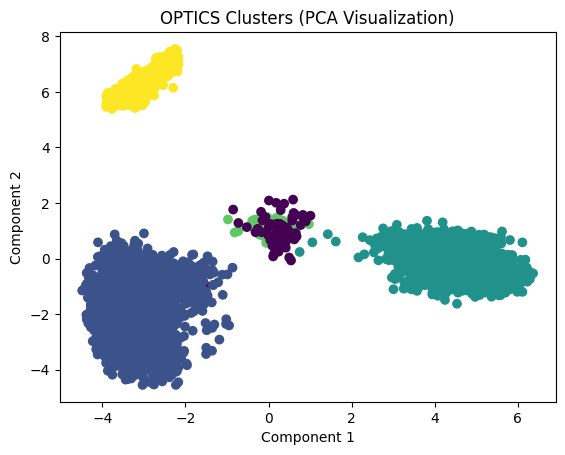

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create a dictionary for mapping cluster labels to colors
color_map = plt.cm.get_cmap('tab10', max(cluster_labels) + 1)  # Adjust colormap as needed
colors = [color_map(label) for label in cluster_labels]

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(concatenated_data)


# Plot the reduced data with cluster labels as colors
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels)
plt.title('OPTICS Clusters (PCA Visualization)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


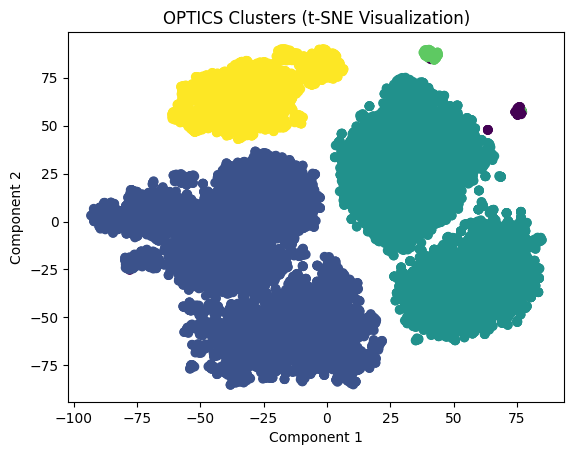

In [ ]:
from sklearn.manifold import TSNE

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2)
data_reduced = tsne.fit_transform(concatenated_data)

# Plot the reduced data with cluster labels as colors
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels)
plt.title('OPTICS Clusters (t-SNE Visualization)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


<ipython-input-49-490760395bbf>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_embedding = torch.tensor(text_embedding)


textr:  (21469,)
kgr:  (21469,)
cluster:  (21469,)


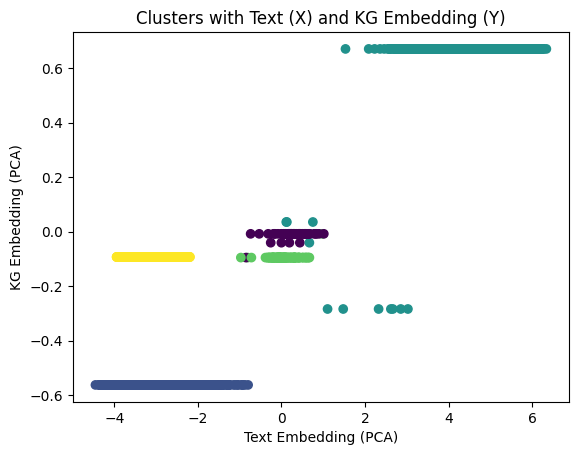

In [ ]:
import pandas as pd
import torch
from torch import nn
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA

# Add cluster labels to the DataFrame
df['cluster'] = cluster_labels

# Separate text and kg embeddings for individual PCA
text_embeddings = df['text'].tolist()  # Assuming 'text' contains lists of tensors
kg_embeddings = df['embedding'].tolist()



# Apply attention to text embeddings before PCA
for i, text_embedding in enumerate(text_embeddings):
    text_embedding = torch.tensor(text_embedding)
    context_vector = attention_model(text_embedding)
    text_embeddings[i] = context_vector.detach().numpy()

# PCA for text embeddings
pca_text = PCA(n_components=1)
text_reduced = pca_text.fit_transform(text_embeddings)

# PCA for KG embeddings
pca_kg = PCA(n_components=1)
kg_reduced = pca_kg.fit_transform(kg_embeddings)

text_reduced = text_reduced.flatten()
kg_reduced = kg_reduced.flatten()
print("textr: ",text_reduced.shape)
print("kgr: ",kg_reduced.shape)
print("cluster: ",df['cluster'].shape)
# Create new DataFrame for plotting
plot_data = pd.DataFrame({
    'text': text_reduced,
    'embedding': kg_reduced,
    'cluster': df['cluster']
})

# Plot the results
plt.scatter(plot_data['text'], plot_data['embedding'], c=plot_data['cluster'])
plt.title('Clusters with Text (X) and KG Embedding (Y)')
plt.xlabel('Text Embedding (PCA)')
plt.ylabel('KG Embedding (PCA)')
plt.show()


In [ ]:
df['cluster'] = cluster_labels
df.to_csv('clusterData.csv')

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# ... (Your code for SentenceAttention, data preparation, and OPTICS clustering)

# Prepare data for the neural network
text_embeddings = df['text'].to_numpy()  # Assuming 'text' contains lists of tensors
cluster_labels = df['cluster'].to_numpy()

# One-hot encode the cluster labels
encoder = OneHotEncoder(sparse=False)  # Dense representation
cluster_labels_encoded = encoder.fit_transform(cluster_labels.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    text_embeddings, cluster_labels_encoded, test_size=0.2, random_state=42
)


# Function to apply SentenceAttention to a batch of text embeddings
def apply_attention(text_batch, attention_model):
    context_vectors = []
    for text_embedding_list in text_batch:
        # Combine tensors within each row
        context_vector = attention_model(torch.tensor(text_embedding_list).to(device))
        context_vectors.append(context_vector)
    return torch.stack(context_vectors).float()
attention_model = SentenceAttention(768).to(device)

# Apply SentenceAttention to create context vectors
X_train = apply_attention(X_train, attention_model)
X_test = apply_attention(X_test, attention_model)

y_train = torch.tensor(y_train).to(device).float()
y_test = torch.tensor(y_test).to(device).float()
# Define the neural network model
class ClusterPredictor(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256).to(device)  # Adjust hidden size as needed
        self.linear2 = nn.Linear(256, 256).to(device)
        self.linear3 = nn.Linear(256, num_classes).to(device)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.linear3(x)
        return x

# Initialize the model
input_size = 768  # Size of the context vector
num_classes = len(encoder.categories_[0])  # Number of unique clusters
clusterPredict = ClusterPredictor(input_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(clusterPredict.parameters(), lr=0.001)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    clusterPredict.train()
    outputs = clusterPredict(torch.tensor(X_train))
    loss = F.mse_loss(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
      # Evaluate on the test set
      clusterPredict.eval()
      with torch.no_grad():
        test_outputs = clusterPredict(X_test)
        loss = F.mse_loss(test_outputs, y_test)  # Use MSE Loss
        print(f'Epoch {epoch+1}, Test Loss (MSE): {loss.item():.4f}')




In [ ]:
print(df['cluster'])

0        0
1        0
2        0
3        0
4        0
        ..
21464    1
21465    1
21466    1
21467    1
21468    1
Name: cluster, Length: 21469, dtype: int64


In [ ]:
batch_size = 16
numEpochs = 20
latent_size = 8
beta = 10000
def train_text_vae(model, train_dataloader, test_dataloader, optimizer, epochs=10):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    text_z_list = []
    text_idx_list = []
    for epoch in range(epochs):
        text_z_list1 = []
        total_train_loss = 0
        total_test_loss = 0
        text_idx_list1 = []
           #  Store indices for text embeddings
        for idx_batch, text_embeddings, cluster_labels in train_dataloader:
              # Add indices to the list
            if text_embeddings.size(1) != batch_size:  # Check batch size
                print("0: ",text_embeddings.size(0))
                print("1: ",text_embeddings.size(1) )
                continue  # Skip smaller batches
            else:
              text_z_list = text_z_list1
              text_idx_list = text_idx_list1
            text_embeddings = text_embeddings.to(device)
            text_idx_list1.extend(idx_batch.tolist())
            cluster_labels = cluster_labels.to(device)

            output, text_z, text_mu, text_logvar = model(text_embeddings, cluster_labels)
            attention_layer = SentenceAttention(768).to(device)  # Initialize attention
            context = attention_layer(text_embeddings)  # Apply attention
            # Calculate reconstruction and KL-Divergence loss
            # (you might need to adjust if a different loss is used)
            text_rc_loss = F.mse_loss(output, context)
            text_kl_loss = -0.5 * torch.sum(1 + text_logvar - text_mu.pow(2) - text_logvar.exp())

            loss = text_rc_loss + beta * text_kl_loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_train_loss += loss.item()
            text_z_list1.append(text_z)

        avg_train_loss = total_train_loss / len(train_dataloader)
        # Test loop (evaluation)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            total_test_loss = 0
            for idx_batch, text_embeddings, cluster_labels in test_dataloader:
                text_embeddings = text_embeddings.to(device)
                cluster_labels = cluster_labels.to(device)
                output, text_z, text_mu, text_logvar = model(text_embeddings, cluster_labels)
                attention_layer = SentenceAttention(768).to(device)  # Initialize attention
                context = attention_layer(text_embeddings)  # Apply attention
                text_rc_loss = F.mse_loss(output, context)
                text_kl_loss = -0.5 * torch.sum(1 + text_logvar - text_mu.pow(2) - text_logvar.exp())
                loss = text_rc_loss + beta * text_kl_loss
                total_test_loss += loss.item()

            avg_test_loss = total_test_loss / len(test_dataloader)
            print(f'Epoch {epoch + 1}: Training Loss - {avg_train_loss:.4f}  Test Loss - {avg_test_loss:.4f}')

        model.train()  # Switch back to training mode

    text_z = torch.cat(text_z_list, dim=0)
    text_indices = torch.tensor(text_idx_list)
    print("text_z: ",text_z.shape)
    print("idx: ",text_z.shape)
    return text_z, textModel, text_indices



import torch.utils.data.dataset as dataset
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoder.fit(df['cluster'].to_numpy().reshape(-1, 1))  # Fit the encoder on cluster labels

class TextVAEDataset(dataset.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text_embedding = self.df.iloc[index]['text'].float()
        cluster_label = self.df.iloc[index]['cluster']
        one_hot_cluster = encoder.transform([[cluster_label]]).flatten()
        one_hot_cluster = torch.tensor(one_hot_cluster).float()
        return index, text_embedding, one_hot_cluster

from torch.nn.utils.rnn import pad_sequence

def text_vae_collate_fn(batch):

    text_embeddings = [item[1] for item in batch]  # Extract text embeddings
    cluster_labels = torch.stack([item[2] for item in batch]).float()
    # Pad the text embeddings
    text_embeddings_padded = pad_sequence(text_embeddings, batch_first=False)
    indexes = [item[0] for item in batch]
    indexes = torch.tensor([item[0] for item in batch]).float()

    return indexes, text_embeddings_padded, cluster_labels


from sklearn.model_selection import train_test_split

# ... (your existing code)

# Split your dataset into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)  # Example 80/20 split

# Create datasets for train and test
dataset_textvae_train = TextVAEDataset(df_train)
dataset_textvae_test = TextVAEDataset(df_test)

# Create dataloaders
text_dataloader_train = DataLoader(
    dataset_textvae_train,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=text_vae_collate_fn
)

text_dataloader_test = DataLoader(
    dataset_textvae_test,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=text_vae_collate_fn
)


textModel = TextVAE(
    bert_embedding_size=768,  # Adjust if using a different BERT model
    hidden_size=256,
    latent_size=latent_size,
    num_labels=len(encoder.categories_[0])
)
optimizer = optim.Adam(textModel.parameters(),lr=0.0001)
text_zFinal, text_encoder_model, text_ids = train_text_vae(textModel, text_dataloader_train, text_dataloader_test, optimizer, epochs = numEpochs)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Ignore all UserWarnings
text_z_dict = dict(zip(text_ids.tolist(), text_zFinal.tolist()))  # Create a dictionary for fast lookup
def train_kg_vae(model, train_dataloader, test_dataloader, optimizer, num_epochs=10):
    model.train()  # Set the KGVAE model to training mode
    kg_z_list = []
    criterion = torch.nn.CosineEmbeddingLoss()  # Initialize the loss function
    kg_idx_list = []
    for epoch in range(num_epochs):
        kg_z_list1 = []
        total_train_loss = 0
        # Training loop
        kg_idx_list1 = []
        for idx_batch, kg_embeddings, cluster_labels in train_dataloader:
            if kg_embeddings.size(0) != batch_size:  # Check batch size
                print("0: ",kg_embeddings.size(0))
                print("1: ",kg_embeddings.size(1))
                continue  # Skip smaller batches
            else:
                kg_z_list=kg_z_list1
                kg_idx_list = kg_idx_list1
            kg_embeddings = kg_embeddings.to(device)
            kg_idx_list1.extend(idx_batch.tolist())
            optimizer.zero_grad()
            index_list = [idx.item() for idx in idx_batch]  # Get indices as Python integers
            text_z_equiv = torch.stack([torch.tensor(text_z_dict[index]) for index in index_list]).to(device)
            kg_recon, kg_z, kg_mu, kg_logvar = model(kg_embeddings, cluster_labels,text_z_equiv)
            # Calculate reconstruction and KL-Divergence loss
            # (you might need to adjust if a different loss is used)
            target = torch.ones(kg_embeddings.size(0)).to(device)  # Target of 1 for similarity
            kg_rc_loss = criterion(kg_recon, kg_embeddings, target)
            kg_kl_loss = -0.5 * torch.sum(1 + kg_logvar - kg_mu.pow(2) - kg_logvar.exp())

            loss = kg_rc_loss + beta * kg_kl_loss  # Beta for KL weighting

            loss.backward()
            optimizer.step()
            kg_z_list1.append(kg_z)
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        # Test loop (evaluation)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            total_test_loss = 0
            for idx_batch, kg_embeddings, cluster_labels in test_dataloader:
                kg_embeddings = kg_embeddings.to(device)
                index_list = [idx.item() for idx in idx_batch]  # Get indices as Python integers
                text_z_equiv = torch.stack([torch.tensor(text_z_dict[index]) for index in index_list]).to(device)
                kg_recon, kg_z, kg_mu, kg_logvar = model(kg_embeddings, cluster_labels,text_z_equiv)
                target = torch.ones(kg_embeddings.size(0)).to(device)  # Target of 1 for similarity
                kg_rc_loss = criterion(kg_recon, kg_embeddings, target)
                kg_kl_loss = -0.5 * torch.sum(1 + kg_logvar - kg_mu.pow(2) - kg_logvar.exp())
                loss = kg_rc_loss + beta * kg_kl_loss  # Beta for KL weighting
                total_test_loss += loss.item()

            avg_test_loss = total_test_loss / len(test_dataloader)
            print(f'Epoch {epoch + 1}: KGVAE Training Loss - {avg_train_loss:.4f} KGVAE Test Loss - {avg_test_loss:.4f}')

        model.train()  # Switch back to training mode

    kg_z = torch.cat(kg_z_list, dim=0)
    kg_indices = torch.tensor(kg_idx_list)
    return kg_z, model_kgvae, kg_indices

import torch.utils.data.dataset as dataset


class KGVAEDataset(dataset.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        kg_embedding = self.df.iloc[index]['embedding']
        kg_embedding_tensor = torch.tensor(kg_embedding).float()
        cluster_label = self.df.iloc[index]['cluster']
        one_hot_cluster = encoder.transform([[cluster_label]]).flatten()
        one_hot_cluster = torch.tensor(one_hot_cluster).float()
        return index, kg_embedding_tensor, one_hot_cluster  # Return the index

def kg_vae_collate_fn(batch):
    kg_embeddings = [item[1] for item in batch]
    kg_embeddings = torch.stack(kg_embeddings)
    # Convert cluster labels to tensors
    cluster_labels = [item[2] for item in batch]
    cluster_labels = torch.stack(cluster_labels).float()

    indexes = [item[0] for item in batch]
    indexes = torch.tensor(indexes).float()

    return indexes, kg_embeddings.to(device), cluster_labels.to(device)



from sklearn.model_selection import train_test_split


# Split your dataset into training and testing sets
df_kg_train, df_kg_test = train_test_split(df, test_size=0.1, random_state=42)  # Example 80/20 split

# Create datasets for train and test
dataset_kgvae_train = KGVAEDataset(df_kg_train)
dataset_kgvae_test = KGVAEDataset(df_kg_test)

# Create dataloaders
kg_dataloader_train = DataLoader(
    dataset_kgvae_train,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=kg_vae_collate_fn
)

kg_dataloader_test = DataLoader(
    dataset_kgvae_test,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=kg_vae_collate_fn
)

model_kgvae = KGVAE(
    kg_embedding_size=300,  # Adjust according to your KG embeddings
    hidden_size=256,
    latent_size=latent_size,
    num_labels=len(encoder.categories_[0])
).to(device)
optimizer_kgvae = optim.Adam(model_kgvae.parameters(), lr=0.0005)  # Adjust learning rate as needed


kg_zFinal, kgDecoder,kg_ids = train_kg_vae(model_kgvae, kg_dataloader_train, kg_dataloader_test, optimizer_kgvae, num_epochs = numEpochs)

kg_zFinal = kg_zFinal.detach().to(device)
del model_kgvae

text_zFinal = text_zFinal.detach().to(device)
del textModel

print("kg_z: ",kg_zFinal.shape)
print("text_z: ",text_zFinal.shape)

# ... (after training both models)



In [ ]:

# Sort together based on indices (assuming indices are in the same order)
aligned_text_z, aligned_kg_z,textid,kgid = zip(*sorted(zip(text_zFinal, kg_zFinal,  text_ids, kg_ids), key=lambda pair: pair[2])) # Sort based on text_ids

text_zFinal = torch.stack(aligned_text_z).to(device)
kg_zFinal = torch.stack(aligned_kg_z).to(device)

print("aligned_kg_z: ", aligned_kg_z.shape)
print("aligned_text_z: ", aligned_text_z.shape)

In [ ]:
print(textid)
print(kgid)

(tensor(0.), tensor(1.), tensor(2.), tensor(3.), tensor(4.), tensor(5.), tensor(6.), tensor(7.), tensor(8.), tensor(9.), tensor(10.), tensor(11.), tensor(12.), tensor(13.), tensor(14.), tensor(15.), tensor(16.), tensor(17.), tensor(18.), tensor(19.), tensor(20.), tensor(21.), tensor(22.), tensor(23.), tensor(24.), tensor(25.), tensor(26.), tensor(27.), tensor(28.), tensor(29.), tensor(30.), tensor(31.), tensor(32.), tensor(33.), tensor(34.), tensor(35.), tensor(36.), tensor(37.), tensor(38.), tensor(39.), tensor(40.), tensor(41.), tensor(42.), tensor(43.), tensor(44.), tensor(45.), tensor(46.), tensor(47.), tensor(48.), tensor(49.), tensor(50.), tensor(51.), tensor(52.), tensor(53.), tensor(54.), tensor(55.), tensor(56.), tensor(57.), tensor(58.), tensor(59.), tensor(60.), tensor(61.), tensor(62.), tensor(63.), tensor(64.), tensor(65.), tensor(66.), tensor(67.), tensor(68.), tensor(69.), tensor(70.), tensor(71.), tensor(72.), tensor(73.), tensor(74.), tensor(75.), tensor(76.), tensor(7

In [ ]:
import math
import torch.utils.data.dataset as dataset

def train_vae_on_cluster(model, dataloader, optimizer, cluster_id,text_z_dict = None, num_epochs=30):
    """Trains either TextVAE or KGVAE on a specific cluster."""
    model.train()
    if cluster_id ==  2:
      text_optimizer = optim.Adam(text_model.parameters(), lr=0.0005)
      num_epochs = 1500
    elif cluster_id == 3:
      num_epochs = 100
    elif cluster_id == -1:
      num_epochs = 2000

    z_list = []
    indexes_list = []
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_test_loss = 0
        #print("dataloader: ",dataloader)
        z_list1=[]
        indexes_list1 = []
        if isinstance(model, TextVAE):
          train_dataloader = dataloaders['text_train']
          test_dataloader = dataloaders['text_test']
        else:
          train_dataloader = dataloaders['kg_train']
          test_dataloader = dataloaders['kg_test']
        for indexes, embeddings in train_dataloader:
            if (isinstance(model, TextVAE) and embeddings.size(1) != batch_size) or (isinstance(model, KGVAE) and embeddings.size(0) != batch_size):
                print("0: ",embeddings.size(0))
                print("1: ",embeddings.size(1))
                continue  # Skip smaller batches2
            else:
              z_list=z_list1
              indexes_list = indexes_list1
            indexes_list.extend(indexes)
            torch.nn.utils.clip_grad_norm_(text_model.parameters(), 5)
            #print(embeddings.shape)
            #print(embeddings)
            #print(embeddings.shape)

            if isinstance(model, TextVAE):  # TextVAE Loss
                output, z, mu, logvar = model(embeddings)
                attention_layer = SentenceAttention(768).to(device)
                context = attention_layer(embeddings)
                rc_loss = F.mse_loss(output, context)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                #print("rc: ",rc_loss)
                #print("kl: ",kl_loss)
                loss = rc_loss + beta * kl_loss  # Adjust weighting if needed
                if math.isnan(loss):
                  print("Real: ",context)
                  print("generated: ",output)
                  print("rc_loss: ",rc_loss)
                  print("kl_loss: ",kl_loss)

            elif isinstance(model, KGVAE):  # KGVAE Loss
                index_list = [idx.item() for idx in indexes]  # Get indices as Python integers
                text_z_equiv = torch.stack([torch.tensor(text_z_dict[index]) for index in index_list]).to(device)
                #print("index1: ",index_list)
                #print("text_z1: ",text_z_equiv)
                output, z, mu, logvar = model(embeddings,None,text_z_equiv)
                rc_loss = 1 - F.cosine_similarity(output, embeddings, dim=-1).mean()
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = rc_loss + beta * kl_loss  # Adjust weighting if needed

            else:
                raise ValueError("Model must be either TextVAE or KGVAE")

            loss.backward()
            optimizer.step()
            z_list.append(z)
            optimizer.zero_grad()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_dataloader)
        if len(dataloader) != 0 and ((num_epochs>=100 and epoch % 50 == 0) or num_epochs < 100):
          model.eval()
          with torch.no_grad():
            for indexes, embeddings in test_dataloader:
              if (isinstance(model, TextVAE) and embeddings.size(1) != batch_size) or (isinstance(model, KGVAE) and embeddings.size(0) != batch_size):
                continue
              if isinstance(model, TextVAE):  # TextVAE Loss
                output, z, mu, logvar = model(embeddings)
                attention_layer = SentenceAttention(768).to(device)
                context = attention_layer(embeddings)
                rc_loss = F.mse_loss(output, context)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                #print("rc: ",rc_loss)
                #print("kl: ",kl_loss)
                loss = rc_loss + beta * kl_loss  # Adjust weighting if needed

              elif isinstance(model, KGVAE):  # KGVAE Loss
                index_list = [idx.item() for idx in indexes]  # Get indices as Python integers
                text_z_equiv = torch.stack([torch.tensor(text_z_dict[index]) for index in index_list]).to(device)
                #print("index2: ",index_list)
                #print("text_z2: ",text_z_equiv)
                output, z, mu, logvar = model(embeddings,None,text_z_equiv)
                rc_loss = 1 - F.cosine_similarity(output, embeddings, dim=-1).mean()
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = rc_loss + beta * kl_loss  # Adjust weighting if needed
              total_test_loss += loss.item()
              z_list.append(z)
              indexes_list.extend(indexes)

            avg_test_loss = total_test_loss / len(test_dataloader)
            print(f'Epoch {epoch+1} (Cluster {cluster_id}): Training Loss - {avg_train_loss:.4f} Test Loss - {avg_test_loss:.4f}')
          model.train()

    z = torch.cat(z_list, dim=0)
    indexes = torch.tensor(indexes_list)
    return indexes, z, model.encoder if isinstance(model, TextVAE) else model.decoder
from torch.nn.utils.rnn import pad_sequence

def text_vae_collate_fn(batch):
    text_embeddings = [torch.tensor(item[1]) for item in batch]  # Extract text embeddings
    text_embeddings_padded = pad_sequence(text_embeddings, batch_first=False)
    indexes = [item[0] for item in batch]
    indexes = torch.tensor(indexes).float()
    return indexes, text_embeddings_padded.to(device)

def kg_vae_collate_fn(batch):
    kg_embeddings = [item[1] for item in batch]
    kg_embeddings = torch.stack(kg_embeddings)

    indexes = [item[0] for item in batch]
    indexes = torch.tensor(indexes).float()
    return indexes, kg_embeddings.to(device)

class TextVAEDataset(dataset.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text_embedding = self.df.iloc[index]['text'].float()
        #print(text_embedding)
        return index, text_embedding

class KGVAEDataset(dataset.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        kg_embedding = self.df.iloc[index]['embedding']
        kg_embedding_tensor = torch.tensor(kg_embedding).float()


        return index, kg_embedding_tensor

# **1. Create Data Loaders for each Cluster**
def create_cluster_dataloaders(df, cluster_labels):
    cluster_dataloaders = {}
    for cluster_id in set(cluster_labels):
        cluster_df = df[df['cluster'] == cluster_id]

        # Split cluster_df into train and test sets
        cluster_df_train, cluster_df_test = train_test_split(
            cluster_df, test_size=0.1, random_state=42
        )

        text_dataset_train = TextVAEDataset(cluster_df_train)
        text_dataloader_train = DataLoader(
            text_dataset_train,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=text_vae_collate_fn
        )

        text_dataset_test = TextVAEDataset(cluster_df_test)
        text_dataloader_test = DataLoader(
            text_dataset_test,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=text_vae_collate_fn
        )


        kg_dataset_train = KGVAEDataset(cluster_df_train)
        kg_dataloader_train = DataLoader(
            kg_dataset_train,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=kg_vae_collate_fn
        )

        kg_dataset_test = KGVAEDataset(cluster_df_test)
        kg_dataloader_test = DataLoader(
            kg_dataset_test,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=kg_vae_collate_fn
        )

        cluster_dataloaders[cluster_id] = {
            'text_train': text_dataloader_train,
            'text_test': text_dataloader_test,
            'kg_train': kg_dataloader_train,
            'kg_test': kg_dataloader_test
        }

    return cluster_dataloaders

# **2. Train VAEs on each Cluster and Store Results**
cluster_dataloaders = create_cluster_dataloaders(df, cluster_labels)  # From OPTICS
database = []  # To store cluster, TextVAE z, and KGVAE z

for cluster_id, dataloaders in cluster_dataloaders.items():
    # Train TextVAE
    text_model = TextVAE(bert_embedding_size=768, hidden_size=256, latent_size=latent_size).to(device)
    text_optimizer = optim.Adam(text_model.parameters(), lr=0.0001)
    torch.nn.utils.clip_grad_norm_(text_model.parameters(), 5)


    # Train KGVAE
    kg_model = KGVAE(kg_embedding_size=300, hidden_size=256, latent_size=latent_size).to(device)
    kg_optimizer = optim.Adam(kg_model.parameters(), lr=0.0001)
    torch.nn.utils.clip_grad_norm_(kg_model.parameters(), 5)

    print("TextVAE: ",cluster_id)
    indexes, text_z, text_encoder = train_vae_on_cluster(
        text_model, dataloaders, text_optimizer, cluster_id
    )
    # Store text_z for the current cluster
    text_z_dict = dict(zip(indexes.tolist(), text_z.tolist()))

    print("KGVAE: ",cluster_id)
    indexes, kg_z, kg_decoder = train_vae_on_cluster(
          kg_model, dataloaders, kg_optimizer, cluster_id, text_z_dict
      )




    # Store in database
    for i in range(len(text_z)):
        database.append({
            'cluster': cluster_id,
            'text_z': text_z[i],
            'kg_z': kg_z[i]
        })

for i in range(len(text_zFinal)):
  database.append({
      'cluster' : -2,
      'text_z': text_zFinal[i],
      'kg_z' : kg_zFinal[i]
      })

# **3. Create DataFrame from Database **
cluster_db_df = pd.DataFrame(database)

Streaming output truncated to the last 5000 lines.
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
Epoch 1551 (Cluster -1): Training Loss - 0.0357 Test Loss - 0.0000
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  1
0:  46
1:  

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import pickle

# Save the ClusterPredict model
with open('cluster_predictor_model.pkl', 'wb') as f:
    pickle.dump(clusterPredict, f)

# Save the DataFrame
cluster_db_df.to_pickle("cluster_db_df.pkl")

# Save the text encoder model
torch.save(text_encoder_model.state_dict(), "text_encoder_model.pth")

# Save the KG decoder model
torch.save(kgDecoder.state_dict(), "kg_decoder_model.pth")


In [ ]:
!cp cluster_db_df.pkl /content/drive/MyDrive/WikiData/cluster_db_df.pkl

!cp text_encoder_model.pth /content/drive/MyDrive/WikiData/text_encoder_model.pth


In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the text encoder model
text_encoder_model = TextVAE(
    bert_embedding_size=768,  # Adjust if using a different BERT model
    hidden_size=256,
    latent_size=2,
    num_labels=5
).to(device)

# Load the DataFrame
cluster_db_df = pd.read_pickle("/content/drive/MyDrive/WikiData/cluster_db_df_cpu.pkl")

text_encoder_model.load_state_dict(torch.load("/content/drive/MyDrive/WikiData/text_encoder_model.pth",map_location=torch.device('cpu')))
text_encoder_model.eval()  # Set to evaluation mode

# Load the KG decoder model
kgDecoder = KGVAE(
    kg_embedding_size=300,  # Adjust according to your KG embeddings
    hidden_size=256,
    latent_size=2,
    num_labels=5
).to(device)
kgDecoder.load_state_dict(torch.load("kg_decoder_model.pth",map_location=torch.device('cpu')))
kgDecoder.eval()

import pickle
class ClusterPredictor(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256).to(device)  # Adjust hidden size as needed
        self.linear2 = nn.Linear(256, 256).to(device)
        self.linear3 = nn.Linear(256, num_classes).to(device)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.linear3(x)
        return x
# Load the ClusterPredict model
with open('cluster_predictor_model.pkl', 'rb') as f:
    clusterPredict = pickle.load(f)




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [9]:
!nvidia-smi

Tue Mar 26 14:47:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              50W / 400W |   9235MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [17]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn

class TextToKGTranslator(nn.Module):
    def __init__(self, z_text_size, kg_z_size, num_clusters=5, hidden_size=128, dropout_p=0.2):
        super().__init__()
        self.num_clusters = num_clusters
        self.linear1 = nn.Linear(z_text_size, hidden_size)
        self.dropout1 = nn.Dropout(p=dropout_p)  # Add dropout
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(p=dropout_p)  # Add dropout
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(p=dropout_p)  # Add dropout
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, kg_z_size)
        self.bn_cluster = ConditionalBatchNorm1d(hidden_size, num_clusters)

    def forward(self, z_text, cluster_label):
        out = torch.relu(self.linear1(z_text))
        out = self.dropout1(out)  # Apply dropout
        out = torch.relu(self.linear2(out))
        out = self.dropout2(out)  # Apply dropout
        out = torch.relu(self.linear3(out))
        out = self.dropout3(out)  # Apply dropout
        out = self.bn_cluster(out, cluster_label)
        out = torch.relu(self.linear4(out))
        kg_z_pred = self.linear5(out)
        return kg_z_pred


latent_size=2
# Instantiate the model
model = TextToKGTranslator(latent_size, latent_size).to(device)  # Assuming both z_text and kg_z are of latent_size

# Define the loss function and optimizer
criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)  # Add weight_decay

epochs = 10000
batch_size = 8

# Data preparation
cluster_data = cluster_db_df.to_numpy()

def convert_to_tensors(data):
    z_text_list = []
    kg_z_list = []
    cluster_list = []
    for row in data:
        z_text_list.append(torch.tensor(row[1]).float())  # Convert tensors to float format
        kg_z_list.append(torch.tensor(row[2]).float())
        cluster_list.append(torch.tensor(row[0]).long())
    return torch.stack(z_text_list).to(device), torch.stack(kg_z_list).to(device), torch.stack(cluster_list).to(device)

# Convert z_text and kg_z elements into tensors
z_text_list, kg_z_list, cluster_list = convert_to_tensors(cluster_data)

# Convert to NumPy arrays (on CPU) before splitting
z_text_np = z_text_list.cpu().numpy()
kg_z_np = kg_z_list.cpu().numpy()
cluster_np = cluster_list.cpu().numpy()
from sklearn.model_selection import train_test_split
# Now perform the split
X_train, X_test, y_train, y_test, cluster_train, cluster_test = train_test_split(
    z_text_np,
    kg_z_np,
    cluster_np,
    test_size=0.2,
    random_state=42,
    stratify=cluster_np
)

# Convert back to tensors (on GPU)
X_train = torch.tensor(X_train).to(device).float()
X_test = torch.tensor(X_test).to(device).float()
y_train = torch.tensor(y_train).to(device).float()
y_test = torch.tensor(y_test).to(device).float()
cluster_train = torch.tensor(cluster_train).long() # Ensure 'int' or 'long' type
cluster_test = torch.tensor(cluster_test).long()

indices = cluster_train == -2

# Modify those specific entries to -1:
cluster_train[indices] = -1

indices = cluster_test == -2

# Modify those specific entries to -1:
cluster_test[indices] = -1
cluster_train += 1
cluster_test += 1
# One-hot encode the cluster labels before the training loop
cluster_encoding_train = F.one_hot(cluster_train, num_classes=model.num_clusters).to(device).float()
cluster_encoding_test = F.one_hot(cluster_test, num_classes=model.num_clusters).to(device).float()


num_train_batches = len(X_train) // batch_size
num_test_batches = len(X_test) // batch_size

# GAN Training Loop
for epoch in range(epochs):
    total_train_loss = 0
    total_test_loss = 0
    for batch_idx in range(num_train_batches):
        # Sample a batch from the dataset
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        z_text = X_train[start_idx:end_idx]
        kg_z = y_train[start_idx:end_idx]
        clusters = cluster_encoding_train[start_idx:end_idx]
        optimizer.zero_grad()
        kg_z_pred = model(z_text,clusters)
        target = torch.ones(batch_size).to(device)  # Labels of 1 for similarity
        loss = criterion(kg_z_pred, kg_z, target)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    with torch.no_grad():  # Disable gradients during evaluation
        for batch_idx in range(num_test_batches):
            # Sample a batch from the dataset
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            # Extract text_z and kg_z for the batch
            z_text = X_test[start_idx:end_idx]
            kg_z = y_test[start_idx:end_idx]
            clusters = cluster_encoding_test[start_idx:end_idx]
            kg_z_pred = model(z_text,clusters)
            target = torch.ones(batch_size).to(device)  # Labels of 1 for similarity
            loss = criterion(kg_z_pred, kg_z, target)
            total_test_loss += loss.item()
    avg_training_loss = total_train_loss / num_train_batches
    avg_test_loss =  total_test_loss / num_test_batches
    print(f'Epoch {epoch+1}: Training Loss - {avg_training_loss:.4f} : Test loss - {avg_test_loss:.4f}')


<ipython-input-17-b29887c30f94>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_text_list.append(torch.tensor(row[1]).float())  # Convert tensors to float format
<ipython-input-17-b29887c30f94>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kg_z_list.append(torch.tensor(row[2]).float())


Epoch 1: Training Loss - 0.9928 : Test loss - 0.9941
Epoch 2: Training Loss - 0.9895 : Test loss - 0.9883
Epoch 3: Training Loss - 0.9880 : Test loss - 0.9851
Epoch 4: Training Loss - 0.9884 : Test loss - 0.9914
Epoch 5: Training Loss - 0.9890 : Test loss - 1.0002
Epoch 6: Training Loss - 0.9889 : Test loss - 1.0011
Epoch 7: Training Loss - 0.9881 : Test loss - 0.9955
Epoch 8: Training Loss - 0.9849 : Test loss - 0.9885
Epoch 9: Training Loss - 0.9893 : Test loss - 1.0042
Epoch 10: Training Loss - 0.9885 : Test loss - 0.9923
Epoch 11: Training Loss - 0.9858 : Test loss - 0.9854
Epoch 12: Training Loss - 0.9865 : Test loss - 0.9920
Epoch 13: Training Loss - 0.9876 : Test loss - 1.0042
Epoch 14: Training Loss - 0.9847 : Test loss - 0.9930
Epoch 15: Training Loss - 0.9851 : Test loss - 0.9924
Epoch 16: Training Loss - 0.9820 : Test loss - 0.9884
Epoch 17: Training Loss - 0.9820 : Test loss - 0.9975
Epoch 18: Training Loss - 0.9811 : Test loss - 0.9925
Epoch 19: Training Loss - 0.9837 : Te

KeyboardInterrupt: 

In [10]:
del model

In [ ]:
print(X_train)
print(y_train)

tensor([[ 1.3028, -0.1273],
        [ 0.5473,  0.7619],
        [-0.4785,  1.6330],
        ...,
        [ 1.1727, -0.5445],
        [-0.1663, -0.5896],
        [-3.5997, -0.8429]], device='cuda:0')
tensor([[-0.0157,  0.7228],
        [-0.2196,  1.1965],
        [-2.1442, -0.1764],
        ...,
        [ 0.4694, -0.4393],
        [-0.1204,  0.0280],
        [ 0.8828,  0.1984]], device='cuda:0')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

noise_dim = latent_size

# Instantiate Generator and Discriminator
generator = Generator(latent_size, 256,6).to(device)
discriminator = Discriminator(latent_size).to(device)

optimizer_generator = optim.Adam(generator.parameters(),lr=0.001)
optimizer_discriminator = optim.Adam(discriminator.parameters(),lr=0.00001)
criterion = nn.BCEWithLogitsLoss()  # Standard for GANs


# Hyperparameters
epochs = 1000
batch_size = 16
num_clusters = cluster_db_df['cluster'].nunique()

# Data preparation
cluster_data = cluster_db_df.to_numpy()
num_batches = len(cluster_data) // batch_size  # Adjust if dataset size is not divisible by batch_size

# GAN Training Loop
for epoch in range(epochs):
    total_gen_loss = 0
    total_dis_loss = 0

    for batch_idx in range(num_batches):
        # Sample a batch from the dataset
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        batch = cluster_data[start_idx:end_idx]

        # Extract text_z and kg_z for the batch
        z_text = torch.stack([row[1] for row in batch]) # Stack individual tensors
        kg_z = torch.stack([row[2] for row in batch])
        cluster_labels = torch.tensor([row[0] for row in batch])  # Explicit conversion to a tensor
        cluster_labels=cluster_labels+2
        # Generator training step
        optimizer_generator.zero_grad()
        #noise = torch.randn(batch_size, noise_dim).to(device)  # Match batch size
        #fake_kg_z = generator(z_text, noise, cluster_labels)
        model
        d_on_fake = discriminator(fake_kg_z.detach())
        target_fake = torch.ones_like(d_on_fake)
        g_loss = criterion(d_on_fake, target_fake)
        total_gen_loss += g_loss.item()
        g_loss.backward()
        optimizer_generator.step()

        # Discriminator training step
        optimizer_discriminator.zero_grad()
        d_real = discriminator(kg_z.detach())
        target_real = torch.ones_like(d_real)
        d_loss_real = criterion(d_real, target_real)

        d_fake = discriminator(fake_kg_z.detach())
        target_fake = torch.zeros_like(d_fake)
        d_loss_fake = criterion(d_fake, target_fake)

        d_loss = d_loss_real + d_loss_fake
        total_dis_loss += d_loss.item()
        d_loss.backward()
        optimizer_discriminator.step()

    avg_gen = total_gen_loss / num_batches  # Average loss over batches
    avg_dis = total_dis_loss / num_batches
    print(f'Epoch {epoch+1}: Generator Loss - {avg_gen:.4f} : Discriminator Loss - {avg_dis:.4f}')

In [12]:
import torch
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModel

# Load pre-trained BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") # Or another suitable BERT model
model1 = AutoModel.from_pretrained("bert-base-uncased")

import torch
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModel


def text_embedding(input_entities):
    all_entity_embeddings = []  # Store embeddings for all entities

    for entity in input_entities:
        entity_embeddings = []
        for sentence in entity['sentences']:
            inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
            outputs = model1(**inputs)
            text_embedding = outputs.last_hidden_state[:, 0, :].to(device)  # CLS token
            entity_embeddings.append(text_embedding)

        # Padding for variable-length entity embeddings
        padded_entity_embeddings = pad_sequence(entity_embeddings, batch_first=False).to(device)
        all_entity_embeddings.append(padded_entity_embeddings)

    return all_entity_embeddings




input_entities = [
    {  # Entity 1
        "sentences": [
            "The vast grasslands of the African savanna support diverse wildlife.",
            "African savannas are characterized by their grassy landscapes and scattered trees.",
            "Elephants, zebras, and giraffes are iconic herbivores of the African savanna.",
            "The seasonal fires on the savanna play a crucial role in maintaining the balance of the ecosystem.",
            "Droughts can be a significant challenge for animal and plant life in the African savanna.",
            "African savannas are found in tropical and subtropical regions.",
            "The savanna is characterized by alternating wet and dry seasons.",
            "Acacia trees are a common sight on the African savanna, their flat tops a distinctive shape.",
            "Tourism focused on wildlife viewing is an important economic activity for communities bordering the savanna.",
            "Overgrazing by livestock can threaten the delicate balance of the savanna ecosystem.",
            "Conservation efforts are vital to protect the unique biodiversity of the African savanna.",

        ]
    },
    {  # Entity 2
        "sentences": [
            "Animals are multicellular organisms.",
            "Animals can move independently in their environment.",
            "Animals have a wide variety of adaptations for survival.",
            "Animals range in size from microscopic organisms to the enormous blue whale.",
            "From insects in your backyard to deep-sea creatures, animals inhabit nearly every corner of the Earth.",
            "Animals can be classified as vertebrates (having a backbone) or invertebrates.",
            "Animals are heterotrophs, meaning they obtain their food by consuming other organisms.",
            "Animals can be herbivores (plant-eaters), carnivores (meat-eaters), or omnivores (eating both plants and animals).",
            "Some animals have specialized feeding structures like sharp teeth, beaks, or filter-feeding mechanisms.",
            "Animals reproduce either sexually or asexually.",
            "Animals exhibit diverse reproductive strategies, from laying eggs to giving birth to live young.",
            "Parental care varies greatly among animal species."
        ]
    },
    {  # Entity 3
        "sentences": [
            "[[Renaissance art]] emphasized [[classical forms]] and [[humanism]].",
            "The intricate patterns of [[fractals]] reveal mathematical beauty.",
            "[[Ancient mythology]] provides insights into the beliefs of early [[civilizations]].",
            "Renaissance artists drew inspiration from the sculptures and architecture of ancient Greece and Rome.",
            "The study of classical philosophy and literature was a cornerstone of Renaissance humanism.",
            "Columns, arches, and symmetry are hallmarks of classical architectural forms.",
            "Humanism placed emphasis on the value of human potential and individual achievement.",
            "Renaissance thinkers questioned traditional authorities and focused on reason and observation.",
            "Humanists believed in the power of education to improve society.",
            "The self-similar patterns of fractals can be found in natural objects like ferns and snowflakes.",
            "Fractals are generated through mathematical formulas, revealing the hidden order within seemingly chaotic patterns.",
            "Fractals have applications in fields ranging from computer graphics to medicine. ",
            "Greek mythology is filled with stories of gods, heroes, and fantastical creatures.",
            "Myths often served to explain natural phenomena or provide moral lessons.",
            "Archaeological discoveries continue to uncover the secrets of ancient civilizations like Egypt and Mesopotamia. "
        ]
    },
    {  # Entity 4
        "sentences": [
           "The [[economic policies]] of the [[1980s]] had a lasting global impact.",
           "Name a large [[country]] in [[America]].",
           "Who was the 22nd president?",
           "The [[industrial revolution]] dramatically changed societies around the world.",
           "The deregulation movements of the 1980s led to significant shifts in the banking and telecommunications industries.",
"In the United States, the 1980s are often remembered for the Reagan Administration's emphasis on free market principles.",
"The fall of the Berlin Wall in 1989 symbolized the end of the Cold War era and opened the path to German reunification.",
"Economic globalization accelerated in the 1980s, facilitated by advances in technology and reductions in trade barriers.",
"The 22nd president of the United States, Grover Cleveland, served two non-consecutive terms, making him also the 24th president.",
"Brazil is the largest country in South America by both area and population, playing a key role in regional politics and economics.",
"The 'War on Drugs' policy initiated in the 1980s had profound effects on both domestic and international law enforcement strategies.",
"The introduction of neoliberal policies in the 1980s impacted labor markets and social welfare systems worldwide.",
"The Chernobyl disaster of 1986 raised global awareness about the potential dangers associated with nuclear power.",
"The 1980s saw the emergence of the Internet from a research and military network to the beginnings of the global information system we know today.",
"The economic policies of the 1980s, including tax cuts and deregulation, are often debated for their impact on income inequality.",
"The space shuttle Challenger disaster in 1986 underscored the risks of space exploration and led to major safety reforms in NASA.",
"The adoption of the Single European Act in 1986 was a significant step towards the creation of the European Single Market.",
"The 1980s cultural landscape was marked by the rise of digital technology, influencing music, video games, and cinema.",
"The environmental movement gained momentum in the 1980s, highlighted by the establishment of Earth Day as a global event for environmental awareness and protection.",
    "Reaganomics, with its focus on tax cuts and deregulation, was a dominant economic policy of the 1980s.",
    "The debate over Keynesian economics vs. supply-side economics shaped policy decisions during the 1980s.",
    "Rising national debt was a key economic issue facing the United States during the 1980s.",
    "The Cold War cast a long shadow over the geopolitical landscape of the 1980s.",
    "The development of personal computers and the rise of MTV mark significant cultural shifts in the 1980s.",
    "Fashion in the 1980s was often characterized by bright colors, big hair, and shoulder pads.",
    "Brazil is the largest country in South America.",
    "Canada shares the longest international border in the world with the United States.",
    "Diverse ecosystems, from the Amazon rainforest to the Andes Mountains, can be found across the countries of America.",
    "Grover Cleveland is the only president to serve two non-consecutive terms.",
    "The Louisiana Purchase was a major acquisition of land negotiated during Thomas Jefferson's presidency.",
    "Abraham Lincoln led the United States through the Civil War.",
    "The invention of the steam engine was a pivotal moment in the Industrial Revolution. ",
    "The Industrial Revolution led to mass migration from rural areas to urban centers. ",
    "New technologies developed during the Industrial Revolution transformed industries like textile production and transportation."
        ]
    },
    {
    # Entity 5
    "sentences": [
       "What is a soft-fleeced animal related to the camel?",  # Alpaca or Llama
       "What is the chemical symbol for gold?",  # Au
       "Gold is a precious metal with high conductivity and resistance to corrosion.",
       "Alpacas are domesticated species of South American camelids, known for their soft wool.",
       "The llama, a close relative of the alpaca, is also used for its wool and as a pack animal.",
       "Gold has been used for coinage, jewelry, and other arts throughout recorded history.",
       "The density of gold is 19.32 grams per cubic centimeter, making it one of the densest elements.",
       "Alpacas and llamas are part of the Andean culture and economy, playing a significant role in traditional practices.",
       "Gold mining impacts environmental ecosystems through the release of toxic substances.",
       "The Incas valued alpacas for their wool and considered them a gift from Pachamama, the earth mother.",
       "Modern uses of gold include electronics, dentistry, and as an investment in the form of bullion and coins.",
       "Selective breeding of alpacas has been practiced for thousands of years to produce a variety of wool colors.",
       "Gold's atomic number is 79, and it is classified as a transition metal in the periodic table.",
       "Conservation efforts are in place to maintain the genetic diversity and health of domesticated alpaca populations.",
       "The extraction and processing of gold are energy-intensive and contribute to greenhouse gas emissions.",
    ]
    },{
    # Entity 6
    "sentences": [
       "Deus sive Natura, meaning 'God or Nature', signifies the equivalence of God and Nature.",
       "This concept suggests that God is not a personal deity but the inherent order and essence of the universe.",
       "Originating from the philosophy of Baruch Spinoza, Deus sive Natura challenges traditional views of God.",
       "Spinoza's framework posits that everything that exists is a part of the singular substance, which is God or Nature.",
       "This perspective emphasizes the unity and interconnectedness of all things within the universe.",
       "Deus sive Natura implies that God's will is equivalent to the natural laws governing the universe.",
       "Spinoza’s philosophy promotes a pantheistic view, seeing God in all aspects of the natural world.",
       "The concept encourages a reverence for nature, seeing it as a manifestation of the divine.",
       "Deus sive Natura has influenced both theological and scientific thought, bridging spirituality with the natural sciences.",
       "Critics of this idea argue that it dilutes the concept of a personal, interactive God.",
       "Supporters find in Deus sive Natura a foundation for environmental ethics and a deeper understanding of our place in the universe.",
       "The notion has sparked debate regarding the nature of divinity, free will, and the meaning of sanctity.",
       "Deus sive Natura is considered a cornerstone in the development of modern philosophical naturalism.",
       "It challenges individuals to find spirituality within the laws and beauty of the natural world, rather than through supernatural beliefs.",
       "The concept has been explored in various forms of art and literature, reflecting humanity's complex relationship with the divine and the natural."
    ]
    },{
    # Entity 7
    "sentences": [
        "Mars, known as the Red Planet, is the fourth planet from the Sun in our solar system.",
        "Its distinctive red color is due to iron oxide, or rust, on its surface.",
        "Mars has the largest volcano in the solar system, Olympus Mons, and a vast canyon, Valles Marineris.",
        "The planet has two small moons, Phobos and Deimos, believed to be captured asteroids.",
        "Evidence suggests that Mars once had liquid water on its surface, indicating the potential for past life.",
        "Mars experiences dust storms, which can cover the entire planet and last for months.",
        "The thin atmosphere of Mars, composed mostly of carbon dioxide, is not suitable for human life.",
        "Mars has polar ice caps that contain frozen water and carbon dioxide, changing size with the seasons.",
        "NASA's rovers, such as Curiosity and Perseverance, have been exploring Mars to study its climate and geology.",
        "The concept of terraforming Mars has been proposed as a way to make the planet habitable for humans.",
        "Mars' gravity is about 38% of Earth's, affecting the potential for human muscle and bone density on the planet.",
        "Scientists believe that studying Mars can reveal much about the early history of our solar system.",
        "There is ongoing research into the possibility of past or present microbial life on Mars.",
        "Human missions to Mars are being planned, with the goal of sending astronauts within the next few decades.",
        "The exploration of Mars has been a significant part of popular culture, inspiring numerous works of science fiction."
    ]
},{
    # Entity 8
    "sentences": [
        "Pizza dough is a foundational element of pizza, made from flour, water, yeast, and salt.",
        "The type of flour used, such as all-purpose or bread flour, can affect the texture and flavor of the dough.",
        "Yeast is essential for the fermentation process, which allows the dough to rise and develop its characteristic flavor.",
        "Kneading the dough is crucial for developing gluten, which gives the dough its elasticity and chewiness.",
        "Pizza dough can be prepared in advance and stored in the refrigerator to enhance its flavor through slow fermentation.",
        "The hydration ratio, or the amount of water relative to flour, is key to determining the dough's texture.",
        "Some pizza dough recipes include olive oil or sugar to enrich the flavor and color of the crust.",
        "Proper proofing, or allowing the dough to rise, is vital for achieving the desired volume and lightness.",
        "The thickness of the rolled-out dough can vary depending on the style of pizza, from thin crust to deep-dish.",
        "Baking pizza dough at a high temperature is important for creating a crisp exterior and soft interior.",
        "Sourdough pizza dough, made from a natural starter, offers a tangy flavor and rustic texture.",
        "The Neapolitan pizza dough, recognized for its simplicity and high-quality ingredients, adheres to strict guidelines for authenticity.",
        "Experimenting with different types of flour, such as whole wheat or gluten-free alternatives, can produce varied dough characteristics.",
        "The resting period after kneading and before shaping allows the gluten network to relax, making the dough easier to work with.",
        "The method of stretching the dough, whether by hand or rolling pin, affects the final texture and airiness of the crust."
    ]
},{
    # Entity 9
    "sentences": [
        "Variational Autoencoders (VAEs) are a type of generative model in machine learning.",
        "They are used to generate new data points that are similar to the input data.",
        "VAEs consist of an encoder, a decoder, and a loss function that measures reconstruction error and the Kullback-Leibler divergence.",
        "The encoder converts input data into a smaller, dense representation in a latent space.",
        "The decoder then reconstructs the input data from this latent representation.",
        "VAEs are particularly known for their application in generating realistic images, texts, and other types of data.",
        "They work by learning a distribution of the input data in the latent space, allowing for the generation of new data points.",
        "One key feature of VAEs is their ability to perform dimensionality reduction, similar to PCA (Principal Component Analysis).",
        "The Kullback-Leibler divergence in the loss function encourages the latent space to follow a probabilistic distribution, typically a Gaussian.",
        "VAEs have been applied in various fields, including drug discovery, anomaly detection, and image super-resolution.",
        "They can also be used for semi-supervised learning, where the model learns from both labeled and unlabeled data.",
        "Unlike traditional autoencoders, VAEs can generate new data points, making them more versatile for tasks like image synthesis.",
        "The variational approach differentiates VAEs from other generative models by introducing a probabilistic interpretation of the encoder’s output.",
        "Training VAEs involves optimizing the balance between the reconstruction fidelity and the regularization of the latent space.",
        "The flexibility and efficiency of VAEs make them a powerful tool in the arsenal of machine learning practitioners and researchers."
    ]
},{
    # Entity 10
    "sentences": [
       "Gubernatorial woman",
       "Who was the most sadistic figure in history?"
       "Gubernatorial woman refers to a female governor or a woman holding the office of a governor.",
       "Who was the most sadistic figure in history? This question explores individuals known for extreme cruelty or brutality throughout history.",
       "Female governors have played significant roles in the political landscapes of their regions, breaking gender barriers and setting precedents.",
       "Historical figures associated with sadism often include tyrants, dictators, and leaders noted for their ruthless policies or acts of violence.",
       "The rise of women in gubernatorial roles highlights the progress in gender equality within political leadership positions.",
       "Sadistic historical figures are frequently subjects of psychological studies to understand the motivations behind their actions.",
       "Gubernatorial women may also advocate for women's rights and work towards inclusive policies in their governance.",
       "Debates about the most sadistic figure in history involve considerations of context, power dynamics, and the impact of their actions over time.",
       "In recent years, there has been an increase in the number of women serving as governors across the world, reflecting a shift in societal norms.",
       "The legacy of sadistic figures in history is often marked by trauma, cultural memory, and the moral lessons drawn from their reigns.",
       "Female governors often face unique challenges and scrutiny in their roles, navigating both political and societal expectations.",
       "Studying sadistic figures in history can provide insights into the darker aspects of human nature and the conditions that enable such behavior.",
       "Gubernatorial women are often pioneers in their fields, setting examples for future generations of female leaders.",
       "The examination of historical cruelty requires a nuanced understanding of historical context, individual psychology, and societal conditions.",
       "The achievements of women in gubernatorial positions contribute to the broader dialogue on diversity and representation in leadership."

    ]
},{
    # Entity 11
    "sentences": [
       "The water buffalo (Bubalus bubalis) is a large bovid originating from South Asia, Southeast Asia, and China.",
       "Domesticated for thousands of years, water buffaloes are critical to agriculture in regions across Asia for plowing fields and irrigation.",
       "There are two main types of water buffalo: the river buffalo of South Asia and the swamp buffalo of Southeast Asia and China.",
       "Water buffaloes are known for their strength and ability to work in wet, marshy lands where other draft animals cannot.",
       "Apart from agricultural work, water buffaloes are also raised for their milk, meat, and hides.",
       "Water buffalo milk is a key ingredient in traditional cheeses in some countries, including mozzarella in Italy.",
       "These animals have a semi-aquatic lifestyle, spending a lot of their time submerged in water to cool off and avoid pests.",
       "Water buffaloes play a significant role in the ecosystems they inhabit, contributing to the biodiversity of wetlands.",
       "The global population of water buffaloes is estimated to be over 200 million, with a significant number in India and China.",
       "Conservation efforts are in place for wild populations of water buffalo, which are threatened by habitat loss and hunting.",
       "Water buffaloes have a social structure, typically forming herds led by a dominant female.",
       "The gestation period for a water buffalo is about 10 to 11 months, with calves being born with a distinctive reddish-brown coat.",
       "They are known for their large, crescent-shaped horns, which can extend up to 2 meters in some individuals.",
       "Water buffaloes have been introduced to other parts of the world, including Australia, for farming and weed control.",
       "Cultural and religious significance of the water buffalo varies across different societies, symbolizing strength, agriculture, and prosperity."
    ]
},{
    # Entity 12
    "sentences": [
        "The Marshall Islands is a country located in the central Pacific Ocean, part of the larger island group of Micronesia.",
        "It consists of 29 atolls and 5 individual islands, totaling over 1,000 individual islets and islands.",
        "The capital of the Marshall Islands is Majuro, which also serves as the main commercial and administrative center.",
        "The Marshall Islands gained independence from the United States in 1986 under the Compact of Free Association.",
        "The islands were significantly impacted by nuclear testing conducted by the United States during the 1940s and 1950s.",
        "The Marshall Islands is known for its vibrant marine life and is a popular destination for scuba diving and snorkeling.",
        "Due to its low elevation, the Marshall Islands is highly vulnerable to the effects of climate change, including sea level rise.",
        "The Marshallese culture is rich in maritime tradition, reflecting the inhabitants' deep connection to the ocean and navigation skills.",
        "The economy of the Marshall Islands is supported by the use of its large ship registry and financial assistance from the United States.",
        "Marshallese is the official language, with English also widely spoken, especially in official settings and education.",
        "The Bikini Atoll, part of the Marshall Islands, is a UNESCO World Heritage Site, recognized for its underwater nuclear test sites.",
        "The Marshall Islands has taken a proactive stance in international forums on issues related to nuclear disarmament and climate change.",
        "Fishing and coconut processing represent important parts of the local economy, alongside growing tourism.",
        "The traditional navigation techniques of the Marshallese, using stick charts and star maps, have gained international recognition.",
        "The Marshall Islands faces challenges such as limited natural resources, reliance on imports, and the need for sustainable development."
    ]
},{
    # Entity 13
    "sentences": [
        "Tristan da Cunha is the most remote inhabited archipelago in the world, located in the South Atlantic Ocean.",
        "It is part of the British Overseas Territory, which also includes Saint Helena and Ascension Island.",
        "The main island of the archipelago is also named Tristan da Cunha and is home to a small population.",
        "Tristan da Cunha is known for its unique ecosystem, with many species that are endemic to the island.",
        "The island is accessible only by sea, with trips from South Africa taking about six days.",
        "The economy of Tristan da Cunha is based on fishing, agriculture, and the sale of postage stamps to collectors.",
        "Due to its remote location, the community on Tristan da Cunha is largely self-sufficient.",
        "The archipelago was discovered in 1506 by Portuguese explorer Tristão da Cunha, but it was not permanently settled until the 19th century.",
        "Tristan da Cunha has an active volcano, Queen Mary's Peak, which last erupted in 1961, leading to the temporary evacuation of the island's inhabitants.",
        "The islanders of Tristan da Cunha have a unique dialect, which is a blend of English, Dutch, and other languages.",
        "Conservation efforts are in place to protect the island's wildlife, including the Tristan albatross and the rockhopper penguins.",
        "Tourism is limited due to the island's remote location, but it offers unique opportunities for eco-tourism and adventure travel.",
        "Tristan da Cunha's isolation has made it a subject of interest for researchers studying biodiversity and isolation's effects on communities.",
        "The island has no airport, making the sea the only way to access this remote community.",
        "The residents of Tristan da Cunha live in the settlement of Edinburgh of the Seven Seas, often referred to as the most remote settlement in the world."
    ]
}


]


text_embeddings = text_embedding(input_entities)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
for te in text_embeddings:
  print(te.shape)
  print(te)

In [22]:
attention_model = SentenceAttention(768)
with torch.no_grad():
    for i, embedding in enumerate(text_embeddings):  # Iterate through entity embeddings
        print("embedding: ",embedding.shape)
        pred_cluster = clusterPredict(attention_model(torch.tensor(embedding.squeeze(0))))  # Predict cluster for the current entity
        print("pred cluster: ",pred_cluster)
        output, z_text2, mu, logvar = text_encoder_model(embedding, pred_cluster)

        print(f"textVAE (Entity {i}): ",z_text2.shape)
        print(z_text2)

        #noise = torch.randn(1, latent_size).to(device)  # Single sample noise
       # output = generator(z_text2,noise)
        output = model(z_text2,pred_cluster)
        print(f"Generator (Entity {i}): ",output.shape)
        print(output)

        output = kgDecoder(output, pred_cluster,z_text2, True)
        print(f"kgVAE (Entity {i}): ",output.shape)
        print(output)

        distances = F.cosine_similarity(output, torch.Tensor(embeddings).to(device), dim=-1)
        top_5_indices = torch.topk(distances, k=5).indices

        print(f"\nQuery Entity:")
        for sentence in input_entities[i]['sentences']:
          print(f" - {sentence}")

        print("Closest Entities:")
        for concept_idx in top_5_indices:
            concept_label = vocabulary[concept_idx.item()]
            distance = distances[concept_idx.item()].item()
            print(f"  - Concept Label: {concept_label} (Similarity: {distance:.4f})")
        print("---")

embedding:  torch.Size([1, 11, 768])
pred cluster:  tensor([-0.0051,  0.7926,  0.1453, -0.0151, -0.0303], device='cuda:0')
textVAE (Entity 0):  torch.Size([11, 2])
tensor([[-1.0798,  0.6861],
        [-1.9397, -1.9505],
        [-0.8973,  0.0808],
        [-0.5469,  0.6816],
        [ 1.4541, -1.4235],
        [ 2.3792,  1.0305],
        [ 0.1086,  2.4681],
        [-1.7044, -1.6954],
        [ 1.0468, -0.9033],
        [-0.0427,  0.2236],
        [-1.3882, -1.0587]], device='cuda:0')
Generator (Entity 0):  torch.Size([11, 2])
tensor([[-0.0948, -0.4208],
        [ 0.0650, -0.4044],
        [-0.0279, -0.3798],
        [-0.0680, -0.2966],
        [-0.3868,  0.7398],
        [-0.3699,  0.1900],
        [ 0.1611, -0.6072],
        [-0.0422, -0.2588],
        [-0.2769,  0.5111],
        [-0.1884, -0.1956],
        [-0.0084, -0.3127]], device='cuda:0')


<ipython-input-22-830182d93559>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_cluster = clusterPredict(attention_model(torch.tensor(embedding.squeeze(0))))  # Predict cluster for the current entity


UnboundLocalError: local variable 'mu' referenced before assignment

In [ ]:
print(output)

tensor([[[ 0.8563,  0.5031, -5.1106,  ...,  3.1372, -2.0765, -0.6397]],

        [[ 1.1766,  0.7233, -6.9593,  ...,  4.2933, -2.7650, -0.8817]],

        [[ 1.1313,  0.6816, -6.6980,  ...,  4.1449, -2.6829, -0.8759]],

        ...,

        [[ 0.9828,  0.5775, -5.6951,  ...,  3.5325, -2.2821, -0.7345]],

        [[ 0.7487,  0.4458, -4.5216,  ...,  2.7731, -1.8405, -0.5475]],

        [[ 0.9645,  0.5989, -5.8459,  ...,  3.5890, -2.3421, -0.7158]]],
       device='cuda:0')
